# Installations, Datapreprocessing and General Algorithms

## Installing the requirements

Installing the necessary Python packages: `kagglehub` for dataset interaction and `scikit-learn` for machine learning utilities.

In [1]:
!pip install -q kagglehub
!pip install -q scikit-learn

## Imports

Importing all required libraries for the project, including PyTorch for deep learning, torchvision for models and datasets, kagglehub for dataset download, and scikit-learn for data splitting.

In [2]:
import torch
import torch.nn as nn
import torchvision.models as models

import kagglehub
import time
import matplotlib.pyplot as plt

import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split

from tqdm.notebook import tqdm

## Loading the Dataset

Downloading the 'plantvillage-dataset' from KaggleHub and printing the local path where the dataset files are stored.

In [3]:
# Download latest version
path = kagglehub.dataset_download("abdallahalidev/plantvillage-dataset")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/abdallahalidev/plantvillage-dataset/versions/3


## SimpleCNN baseline

This cell defines `SimpleCNN`, a custom convolutional neural network for baseline comparison, and `get_model`, a helper function to instantiate different models (SimpleCNN, MobileNet, EfficientNet).

In [4]:

class SimpleCNN(nn.Module):
    """A lightweight baseline CNN for comparison."""
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(32 * 56 * 56, 128), # Assuming 224x224 input
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        return self.classifier(x)

def get_model(model_name, num_classes):
    if model_name == "mobilenet":
        model = models.mobilenet_v3_small(pretrained=True)
        model.classifier[3] = nn.Linear(model.classifier[3].in_features, num_classes)
    elif model_name == "efficientnet":
        model = models.efficientnet_b0(pretrained=True)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
    else:
        model = SimpleCNN(num_classes)
    return model

## Other Functions

This cell defines the `benchmark_model` function, which measures the average inference latency of a given model on a dataloader.

In [5]:
def benchmark_model(model, dataloader, device):
    model.eval()
    total_time = 0
    iterations = 0

    with torch.no_grad():
        for inputs, _ in dataloader:
            inputs = inputs.to(device)

            start_time = time.time()
            _ = model(inputs)
            end_time = time.time()

            total_time += (end_time - start_time)
            iterations += 1
            if iterations >= 100: break

    avg_latency = (total_time / iterations) * 1000
    print(f"Average Inference Latency: {avg_latency:.2f} ms")
    return avg_latency

This cell defines the `plot_results` function, a utility to visualize training loss and validation accuracy curves for model performance analysis.

In [6]:
def plot_results(losses, accuracies, model_name="Model", save_name="training_curves.png"):
    """
    Universal plotting function for training metrics.
    - model_name: String to include in the titles.
    - save_name: Filename for the saved image.
    """
    plt.figure(figsize=(12, 5))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(losses, label='Training Loss', marker='o', color='blue')
    plt.title(f'{model_name}: Training Loss per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(accuracies, label='Validation Accuracy', color='green', marker='o')
    plt.title(f'{model_name}: Validation Accuracy per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.savefig(save_name)
    plt.show()


## Data Preprocessing

This cell sets up data preprocessing, including image transformations, loading the PlantVillage dataset, and splitting it into training and validation sets with DataLoaders. It also prints the number of classes and sample labels.

In [7]:

# 1. Dataset path
DATA_DIR = os.path.join(path, "plantvillage dataset", "color")

# 2. Transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# 3. Dataset
full_dataset = datasets.ImageFolder(DATA_DIR, transform=transform)

indices = list(range(len(full_dataset)))
train_idx, val_idx = train_test_split(
    indices, test_size=0.2, shuffle=True, random_state=42
)

train_loader = DataLoader(
    Subset(full_dataset, train_idx),
    batch_size=64,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

val_loader = DataLoader(
    Subset(full_dataset, val_idx),
    batch_size=64,
    num_workers=2,
    pin_memory=True
)

# Diagnostics
num_classes = len(full_dataset.classes)
print("Number of classes:", num_classes)

for _, labels in train_loader:
    print("Unique train labels:", labels.unique())
    break


Number of classes: 38
Unique train labels: tensor([ 0,  1,  4,  5,  6,  9, 10, 11, 12, 13, 15, 16, 18, 20, 21, 24, 25, 26,
        27, 28, 30, 32, 33, 34, 35, 37])


# Training and Evaluating the 3 Models

## Simple Vanilla CNN Training Setup

This cell initializes the `SimpleCNN` model, sets up the loss function (`CrossEntropyLoss`), optimizer (`Adam`), and mixed precision training for the vanilla model. It also defines `train_one_epoch_vanilla` for a single training loop.

In [8]:

# Define the device for training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 1. Initialize the Vanilla Model
model_vanilla = SimpleCNN(num_classes)
model_vanilla.to(device)

# Note: For Vanilla CNN, we do NOT freeze any layers because
# there is no pre-trained backbone; the whole network needs to learn.

# 2. Training setup for Vanilla
criterion_vanilla = nn.CrossEntropyLoss()
# Optimizer tracks all parameters for the vanilla model
optimizer_vanilla = optim.Adam(model_vanilla.parameters(), lr=1e-3)

# Mixed Precision setup
use_amp = device.type == "cuda"
scaler_vanilla = torch.amp.GradScaler(enabled=use_amp)

def train_one_epoch_vanilla():
    model_vanilla.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer_vanilla.zero_grad()

        # Autocast for efficiency on GPU
        with torch.amp.autocast(device_type='cuda', enabled=use_amp):
            outputs = model_vanilla(images)
            loss = criterion_vanilla(outputs, labels)

        scaler_vanilla.scale(loss).backward()
        scaler_vanilla.step(optimizer_vanilla)
        scaler_vanilla.update()

        running_loss += loss.item()

    return running_loss / len(train_loader)

Using device: cuda


Executing the training loop for the `SimpleCNN` model over 5 epochs, recording training loss and validation accuracy. It then saves the trained model weights.

In [9]:


NUM_EPOCHS = 5
train_losses_vanilla = []
val_accuracies_vanilla = []

print(f"Starting training on {device}...")

for epoch in range(NUM_EPOCHS):
    # Training - Calling the vanilla specific function
    avg_train_loss = train_one_epoch_vanilla()
    train_losses_vanilla.append(avg_train_loss)

    # Validation - MUST use model_vanilla
    model_vanilla.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            with torch.amp.autocast('cuda', enabled=use_amp):
                # Use model_vanilla here!
                outputs = model_vanilla(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    acc = 100 * correct / total
    val_accuracies_vanilla.append(acc)

    print(f"Epoch {epoch+1}/{NUM_EPOCHS} | Loss: {avg_train_loss:.4f} | Val Acc: {acc:.2f}%")

# Save the vanilla weights as a separate artifact
torch.save(model_vanilla.state_dict(), 'vanilla_cnn_model.pth')

Starting training on cuda...
Epoch 1/5 | Loss: 1.1394 | Val Acc: 85.71%
Epoch 2/5 | Loss: 0.3293 | Val Acc: 87.16%
Epoch 3/5 | Loss: 0.1499 | Val Acc: 88.55%
Epoch 4/5 | Loss: 0.0712 | Val Acc: 89.61%
Epoch 5/5 | Loss: 0.0574 | Val Acc: 87.22%


This cell plots the training loss and validation accuracy curves for the `SimpleCNN` model, saving the plot as 'vanilla_curves.png'.

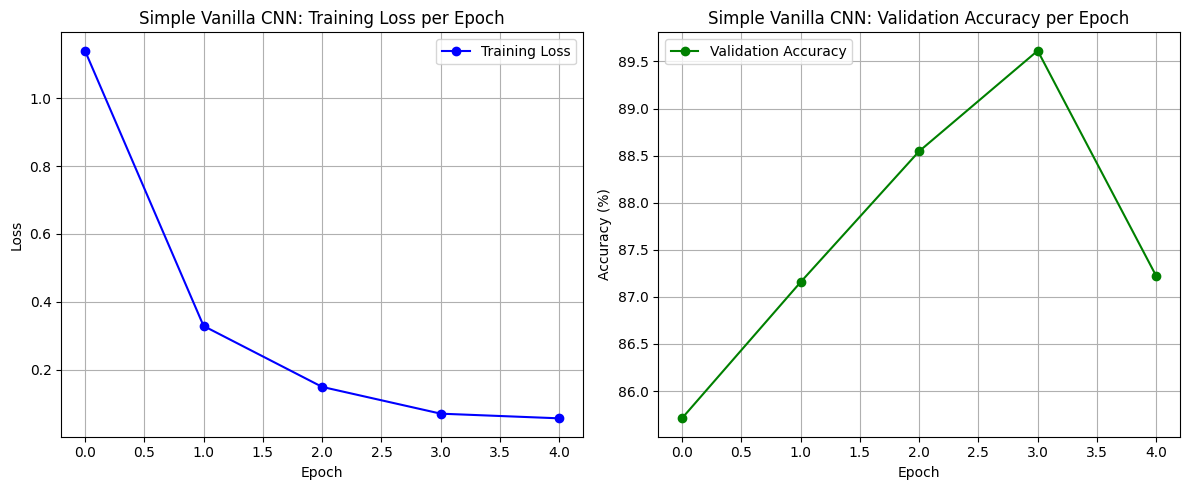

In [10]:
plot_results(train_losses_vanilla, val_accuracies_vanilla, "Simple Vanilla CNN", "vanilla_curves.png")

## MobileNetV3

Setting up the MobileNetV3 model: loading pre-trained weights, replacing the classifier head for `num_classes`, freezing the feature extractor, and configuring the optimizer and mixed precision scaler. It also defines `train_one_epoch_mobile`.

In [11]:
# 4. Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.mobilenet_v3_small(weights='DEFAULT')
model.classifier[3] = nn.Linear(model.classifier[3].in_features, num_classes)
model.to(device)

# Freeze backbone
for param in model.features.parameters():
    param.requires_grad = False

# 5. Training setup
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=1e-3)

use_amp = device.type == "cuda"
scaler = torch.amp.GradScaler(enabled=use_amp)

def train_one_epoch_mobile():
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        with torch.amp.autocast(device_type='cuda', enabled=use_amp):
            outputs = model(images)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()

    return running_loss / len(train_loader)

This cell trains the MobileNetV3 model for 5 epochs, logging the training loss and validation accuracy for each epoch. Finally, it saves the trained model's state dictionary.

In [12]:


NUM_EPOCHS = 5
train_losses_mobile = []
val_accuracies_mobile = []

print(f"Starting training on {device}...")

for epoch in range(NUM_EPOCHS):
    # Training
    avg_train_loss = train_one_epoch_mobile()
    train_losses_mobile.append(avg_train_loss)

    # Validation
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            with torch.amp.autocast('cuda'):
                outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    acc = 100 * correct / total
    val_accuracies_mobile.append(acc)

    print(f"Epoch {epoch+1}/{NUM_EPOCHS} | Loss: {avg_train_loss:.4f} | Val Acc: {acc:.2f}%")

# Save the model weights - this is a required artifact!
torch.save(model.state_dict(), 'plant_disease_model.pth')

Starting training on cuda...
Epoch 1/5 | Loss: 0.3866 | Val Acc: 93.72%
Epoch 2/5 | Loss: 0.1568 | Val Acc: 95.88%
Epoch 3/5 | Loss: 0.1174 | Val Acc: 95.95%
Epoch 4/5 | Loss: 0.0891 | Val Acc: 96.19%
Epoch 5/5 | Loss: 0.0775 | Val Acc: 96.59%


Visualizing the training performance of MobileNetV3 by plotting its training loss and validation accuracy, saving the graph as 'mobilenet_curves.png'.

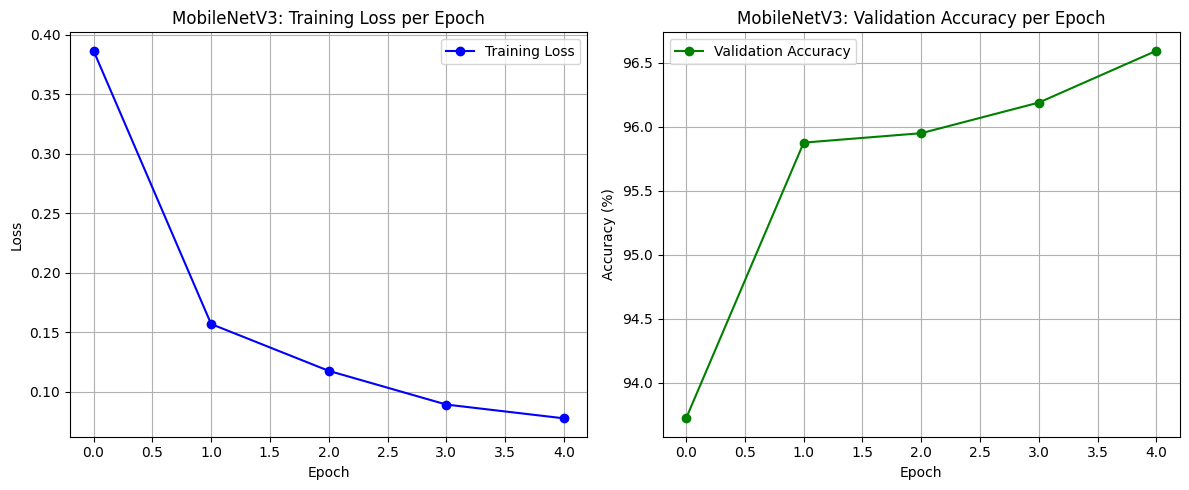

In [13]:
plot_results(train_losses_mobile, val_accuracies_mobile, "MobileNetV3", "mobilenet_curves.png")

## EfficientNet-B0

This cell initializes the EfficientNet-B0 model, updates its classification head for the specific number of classes, freezes the feature extraction layers, and configures the optimizer and mixed precision scaler. It also defines `train_one_epoch_eff`.

In [14]:
# 4. Model (EfficientNet)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pre-trained EfficientNet-B0
model_eff = models.efficientnet_b0(weights='DEFAULT')

# Update the classification head
# For EfficientNet, the classifier is a Sequential block where the
# dropout is at index 0 and the linear layer is at index 1.
in_features = model_eff.classifier[1].in_features
model_eff.classifier[1] = nn.Linear(in_features, num_classes)
model_eff.to(device)

# Freeze backbone (feature extractor)
for param in model_eff.features.parameters():
    param.requires_grad = False

# 5. Training setup for EfficientNet
criterion_eff = nn.CrossEntropyLoss()
# Ensure the optimizer only updates the unfrozen classifier parameters
optimizer_eff = optim.Adam(model_eff.classifier.parameters(), lr=1e-3)

use_amp = device.type == "cuda"
scaler_eff = torch.amp.GradScaler(enabled=use_amp)

def train_one_epoch_eff():
    model_eff.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer_eff.zero_grad()

        with torch.amp.autocast(device_type='cuda', enabled=use_amp):
            outputs = model_eff(images)
            loss = criterion_eff(outputs, labels)

        scaler_eff.scale(loss).backward()
        scaler_eff.step(optimizer_eff)
        scaler_eff.update()

        running_loss += loss.item()

    return running_loss / len(train_loader)

Executing the training process for the EfficientNet-B0 model over 5 epochs, tracking and printing the training loss and validation accuracy. After training, it saves the model's weights.

In [15]:
from tqdm.notebook import tqdm

# Number of epochs for the benchmark
NUM_EPOCHS = 5
train_losses_eff = []
val_accuracies_eff = []

print(f"Starting EfficientNet training on {device}...")

for epoch in range(NUM_EPOCHS):
    # 1. Training Phase
    # Note: Use the specific efficientnet training function defined earlier
    avg_train_loss = train_one_epoch_eff()
    train_losses_eff.append(avg_train_loss)

    # 2. Validation Phase
    model_eff.eval() # Ensure the model is in evaluation mode
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            # Using mixed precision (AMP) for faster validation if available
            with torch.amp.autocast('cuda', enabled=use_amp):
                outputs = model_eff(images)

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    acc = 100 * correct / total
    val_accuracies_eff.append(acc)

    print(f"Epoch {epoch+1}/{NUM_EPOCHS} | Loss: {avg_train_loss:.4f} | Val Acc: {acc:.2f}%")

# 3. Save the EfficientNet weights - required artifact for the report
torch.save(model_eff.state_dict(), 'efficientnet_plant_model.pth')

Starting EfficientNet training on cuda...
Epoch 1/5 | Loss: 0.6335 | Val Acc: 94.58%
Epoch 2/5 | Loss: 0.2201 | Val Acc: 95.35%
Epoch 3/5 | Loss: 0.1690 | Val Acc: 96.03%
Epoch 4/5 | Loss: 0.1416 | Val Acc: 96.45%
Epoch 5/5 | Loss: 0.1299 | Val Acc: 96.64%


Generating and displaying plots for the training loss and validation accuracy of the EfficientNet-B0 model, saving the resulting image as 'efficientnet_curves.png'.

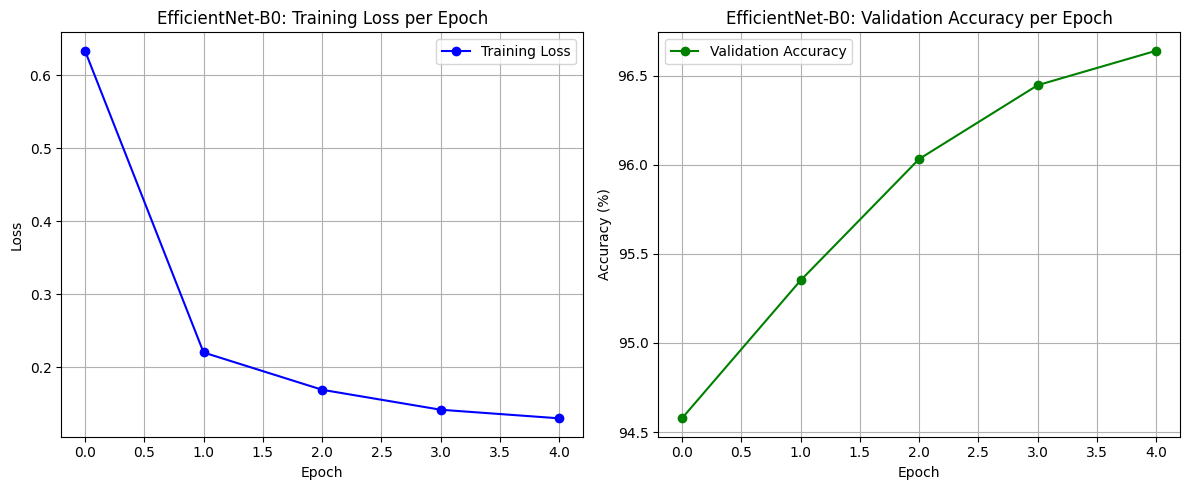

In [16]:
plot_results(train_losses_eff, val_accuracies_eff, "EfficientNet-B0", "efficientnet_curves.png")

# Evaluation and Comparisson

In this cell I defined a function which evaluates the model for several parameters which are to be compared between all of the trained models.

In [17]:
from sklearn.metrics import f1_score, classification_report
import numpy as np

def evaluate_model(model, dataloader, device, model_name="Model"):
    """
    Evaluates the model for accuracy, F1-score, and latency.
    """
    model.eval()
    all_preds = []
    all_labels = []
    
    print(f"--- Evaluating {model_name} ---")
    
    # 1. Performance Metrics
    with torch.no_grad():
        for images, labels in tqdm(dataloader):
            images, labels = images.to(device), labels.to(device)
            with torch.amp.autocast('cuda', enabled=use_amp):
                outputs = model(images)
            
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate Metrics
    accuracy = 100 * (np.array(all_preds) == np.array(all_labels)).mean()
    f1 = f1_score(all_labels, all_preds, average='weighted')
    
    # 2. Latency Benchmarking
    latency = benchmark_model(model, dataloader, device)
    
    print(f"Accuracy: {accuracy:.2f}%")
    print(f"F1-Score (Weighted): {f1:.4f}")
    print(f"Latency: {latency:.2f} ms\n")
    
    return {
        "accuracy": accuracy,
        "f1_score": f1,
        "latency": latency
    }



Now let's see the results

In [18]:
vanilla_metrics = evaluate_model(model_vanilla, val_loader, device, "Vanilla CNN")
mobile_metrics = evaluate_model(model, val_loader, device, "MobileNetV3")
eff_metrics = evaluate_model(model_eff, val_loader, device, "EfficientNet-B0")

--- Evaluating Vanilla CNN ---


  0%|          | 0/170 [00:00<?, ?it/s]

Average Inference Latency: 32.10 ms
Accuracy: 87.22%
F1-Score (Weighted): 0.8723
Latency: 32.10 ms

--- Evaluating MobileNetV3 ---


  0%|          | 0/170 [00:00<?, ?it/s]

Average Inference Latency: 23.10 ms
Accuracy: 96.59%
F1-Score (Weighted): 0.9657
Latency: 23.10 ms

--- Evaluating EfficientNet-B0 ---


  0%|          | 0/170 [00:00<?, ?it/s]

Average Inference Latency: 39.37 ms
Accuracy: 96.64%
F1-Score (Weighted): 0.9662
Latency: 39.37 ms

